Scoring functions are defined for each of the four games to simulate game play. Each game's score is determined based on the most recent click, the current background color, and the prior two clicks and background colors. 

In [34]:
def game1_score(click, env_white, prior_clicks, prior_bgs):
    """"This game will be to click green boxes. Each click of a green box 
    adds points to a player's score. Each click of a red or blue box has 
    no effect on a player's score."""
    
    if click == "green":
        return 1

    return 0 
    
    
def game2_score(click, env_white, prior_clicks, prior_bgs):
    """"The objective of the game is to click the blue square as many times 
    as possible while the black background is present and to also click on 
    the green square as many times as possible while the white background 
    is present. Each of these actions results in one point being awarded. 
    However, if the blue square is clicked while the white background or if 
    the green background is clicked while the black background is present, 
    three points are docked from the score. The red square is neutral and 
    serves no purpose other than changing the background color."""
    
    if env_white:
        if click == "green":
            return 1
        else: 
            return 0 #changed to match hyp (no negative)
        
    elif not env_white:
        if click == "blue":
            return 1 
        else:
            return 0 #changed to match hypotheses
 
def game3_score(click, env_white, prior_clicks, prior_bgs):
    """"Get one point every time click any red, then any green, then any blue 
    during night. Have to click in that order. When background is white, no 
    points or penalties. Have to start from beginning of order whenever it 
    switches back to night.
    """
    
    if not env_white: 
        if click == "blue":
            if (prior_bgs[-1] == False) and (prior_clicks[-1] == "green"):
                return 1
    return 0 
 
def game4_score(click, env_white, prior_clicks, prior_bgs):
    """Have to click on blue, green, red in repeating order. Points
    are given independent of the color of the background.
    
    (Scoring changed from above specification for game plaly so only requires history of 3 clicks)
    """
    
    if click == "red":
        if (prior_clicks[-1] == "green") and (prior_clicks[-2] == "blue"):
                return 1
    
    return 0 
    

Next we define a recursive function that simulates a person "playing" one of the four games. Priors are passed in, and noise is randomly generated and added to the priors based on the "memory" parameters. In the simulated game play, a hypothesis is sampled from the noisy priors that can be tested with the current background color of the environment. The hypothesis is tested by selecting the blocks in the order required by the hypothesis to observe +1 point in the given background condition. The hypothesis stops being tested if the background color required for the hypothesis changes or if rewards are observed that are inconsistent with the hypothesis. If no hypothesis can be sampled that can be tested in the current environment condition, a random click will be executed to attempt to change the background color. 

In [44]:
import numpy as np

def play_game(hypotheses, priors, memory, game, prior_clicks, prior_bgs, env_bg_white, num_clicks, bg_change_prob=0.2):
    """
    Function that simulates game human play. Samples hypothesis from distribution
    using current of each hypothesis. Selects actions based on hypothesis sampled. 
    Stops testing hypothesis as soon as observed rewards are inconsistent with the hypothesis. 
    
    Inputs: 
    - hypotheses: categorical distribution representing all possible hypotheses 
    - priors: array of normalized priors for respective hypotheses
    - memory: tuple of (mean, std) for noise added after each update to priors 
    - game: reward function of game to simulate reward observed when selecting different moves
    - env_bg_init: initialization of environment background (either black or white)
    - bg_change_prob: likelihood of a change in background color after each click  
    
    Future directions: explore other handicaps to make more human-like such as memory loss.
    For now keeping model the exact same as inference model w/ memory of 3 clicks.
    """

    #introduce noise to priors based on memory 
    priors_array = np.array(priors)
    priors_array = priors_array + np.random.normal(memory[0], memory[1], len(priors))
    priors_array = list(np.clip(priors_array, 0,1))
    priors = [float(i)/sum(priors) for i in priors]
    
    #Sample a hypothesis that is testable with the current background
    consistent_hyp_found = False
    
    for i in range(1000):
        sampled_hypothesis = np.random.choice(hypotheses, p=priors)
        if sampled_hypothesis['either'] or (sampled_hypothesis['white'] and env_bg_white) or (sampled_hypothesis['black'] and not env_bg_white):
            consistent_hyp_found = True
            break
    
    #Select clicks to test based on hypothesis and environment background
    if consistent_hyp_found: 
        if sampled_hypothesis['either']: 
            sampled_hypothesis_clicks = sampled_hypothesis['either']
        elif env_bg_white:
            sampled_hypothesis_clicks = sampled_hypothesis['white']
        elif not env_bg_white:
            sampled_hypothesis_clicks = sampled_hypothesis['black']  
    
    #If no hypothesis was found after 1000 samples, then most likely there is not a remaining 
    #hypothesis that is consistent with the current background color. Click a random block
    #(in this case set to be red) to try and change the background color. 
    else: 
        sampled_hypothesis_clicks = ["red"]
    
    #Simulate testing the hypothesis in the game by clicking each component of hypothesis in order 
    for click in sampled_hypothesis_clicks: 
        
        num_clicks+=1
        bg_change = False
    
        #get reward after click from game scoring function
        observed_reward = game(click, env_bg_white, prior_clicks, prior_bgs)  
        
        #create evidence tuple (c1,c2,c3,bg1,bg2,bg3,reward)
        #c3 and bg3 represent the most recent click and associated background
        evidence = prior_clicks+[click]+prior_bgs+[env_bg_white]+[observed_reward]
        
        #check to see if observed reward is consistent with the hypothesis
        expected_reward = check_hypothesis(sampled_hypothesis, evidence)
        
        #Before breaking out of the loop, add the click just tested and associated background
        #to prior_clicks and prior_bgs. Only maintain a memory of 2 previous clicks (3 total)
        #as done in the original inference model.
        prior_clicks = prior_clicks[1:]+[click]
        prior_bgs = prior_bgs[1:]+[env_bg_white]
 
        #Simulate play by changing background with pre-defined probability after each click
        if np.random.random() < bg_change_prob: 
            bg_change = True
            env_bg_white = not env_bg_white

        #If observed outcome inconsistent with hypothesis, break out of loop and stop testing hypothesis
        if expected_reward != observed_reward:
          #  print('expected reward not consistent')
            break 
            
        #If background changes, make sure that player can continue to test the same hypothesis with the 
        #new background (specification defined for "either", or specification defined for both "black"
        #and "white"). If so, switch specification being tested to the one of the appropriate background. 
        #Otherwise, stop testing hypothesis and sample a new one.
        if bg_change:
            if sampled_hypothesis['either']: 
                continue   
            elif not env_bg_white:
                if not sampled_hypothesis['black']: 
                    break
                else: 
                    sampled_hypothesis_clicks = sampled_hypothesis['black']
            elif env_bg_white:
                if not sampled_hypothesis['white']:
                    break
                else: 
                    sampled_hypothesis_clicks = sampled_hypothesis['white']
    
    #update all hypotheses based on evidence
    normalized_posteriors = update_hypotheses(hypotheses, priors, evidence)
    
    #if model certain about correct hypothesis, break
    if any([x>0.95 for x in normalized_posteriors]): 
        #h= normalized_posteriors.index(1)
        #print(h)
        #print("Inferred specification:", hypotheses[h])
        #print("Number of clicks:", num_clicks)
        return num_clicks
    else: 
        num_clicks = play_game(hypotheses, normalized_posteriors, memory, game, prior_clicks, prior_bgs, env_bg_white, num_clicks)
        return num_clicks
        
def check_hypothesis(rule, evidence):
    """Check to see if the rule's specification is defined for the background of the last click
        and that the background history of observations matches the required rule background history.
        Based on this information check to see if the expected reward matches the observed reward. 
        
        Multiple ways we could go about this such as sampling-based, right now just updating all.
        
        """
    if rule["either"]: 
        rule_length = len(rule["either"])
        expected_reward = rule["either"] == list(evidence[-4-rule_length:-4])
        return expected_reward
            
    expected_reward_black = 0 
    if rule["black"]:
        rule_length = len(rule["black"])
        if evidence[-1-rule_length:-1] == [False]*rule_length:
            expected_reward_black = rule["black"] == list(evidence[-4-rule_length:-4])
            
    expected_reward_white=0
    if rule["white"]:
        rule_length = len(rule["white"])
        if evidence[-1-rule_length:-1] == [True]*rule_length:
            expected_reward_white = rule["white"] == list(evidence[-4-rule_length:-4])
        
    return expected_reward_black or expected_reward_white

def update_hypotheses(hypotheses, priors, evidence):
    """For each remaining hypothesis, check if evidence is consistent with hypothesis or 
    not. If evidence is not consistent, set probability to zero. Normalize final set of 
    probabilities.
    
    Input: 
    - hypotheses (list of dictionaries describing each rule)
    - priors (list of priors associated to hypothesis of same index)
    - evidence (tuple of 7 values containing: the last 3 clicks, 
      the background of the last 3 clicks, and the observed reward,
      e.g. (c1=red,c2=red,c3=blue,bg1=black,bg2=black,bg3=white,r=0)  
    """
    posterior = priors.copy()
    
    for i, rule in enumerate(hypotheses):
        
        expected_reward = check_hypothesis(rule,evidence)
    
        if expected_reward != evidence[-1]:
            posterior[i]=0
    
    normalized_posteriors = [float(i)/sum(posterior) for i in posterior]
    return normalized_posteriors
        

We can explore the effects of changing the "memory" of the individual as well as the effects of different initializations of the priors. 

Changing the "memory" of an individual can be simulated by changing the parameters of the Gaussian noise added to priors after each belief update. Adding no noise to the priors simulates an individual with perfect memory, that will never consider a hypothesis that was previously demonstrated to be false. If we maintain noise with a mean of 0 but increase the standard deviation, we can simulate imperfect memory such as reconsidering hypotheses that were previously proven to be inconsistent with observations. 

In [109]:
#Different ways to initialize and update priors

#By defined "type" as previously doing
def initialize_by_type(hypotheses):
    return [1/h["type"] for h in hypotheses]

#By e^type
def initialize_exp_by_type(hypotheses):
    return [1/np.exp(h["type"]) for h in hypotheses]


Previously we were looking at initializing priors based on asigned "types" for each hypothesis. A hypothesis's prior was set as 1/type, to set more complex hypotheses as less likely. We can study different relationships such as 1/$e^{\text{type}}$.

In [128]:
#Different types of memory
perfect_memory = (0,0)
good_memory = (0, 0.05)
poor_memory = (0, 0.2)

Now we can define a wrapper function that plays each of the four games for each combination of memory and prior initialization type we want to test. 

In [129]:
import itertools

def test_combinations(memory_types, prior_initializations):
    """
    Wrapper function that takes in the memory types and the prior initializations and plays 
    each game with each possible combination. 
    
    Inputs:
    - memory_types: list of tuples that give (mean,std) of nosie added to priors after updates. 
    - prior_initializations: list of functions that initialize priors based on hypotheses.
    
    Outputs: 
    - Dictionary of dictionaries. Keys are tuples of (memory_type, prior_initialization) combinations. 
      Values are dictionaries representing game play for that combination. Game play dictionaries 
      have each of the four games as a key, with the corresponding value as a list of the number of 
      clicks until simulated player certainty for 100 simulated games. 
    """
    
    hypotheses = [{'type': 2, 'black': ['red'], 'white': False, 'either': False, 'ID': 0}, {'type': 2, 'black': ['green'], 'white': False, 'either': False, 'ID': 1}, {'type': 2, 'black': ['blue'], 'white': False, 'either': False, 'ID': 2}, {'type': 3, 'black': ['red', 'red'], 'white': False, 'either': False, 'ID': 3}, {'type': 3, 'black': ['red', 'green'], 'white': False, 'either': False, 'ID': 4}, {'type': 3, 'black': ['red', 'blue'], 'white': False, 'either': False, 'ID': 5}, {'type': 3, 'black': ['green', 'red'], 'white': False, 'either': False, 'ID': 6}, {'type': 3, 'black': ['green', 'green'], 'white': False, 'either': False, 'ID': 7}, {'type': 3, 'black': ['green', 'blue'], 'white': False, 'either': False, 'ID': 8}, {'type': 3, 'black': ['blue', 'red'], 'white': False, 'either': False, 'ID': 9}, {'type': 3, 'black': ['blue', 'green'], 'white': False, 'either': False, 'ID': 10}, {'type': 3, 'black': ['blue', 'blue'], 'white': False, 'either': False, 'ID': 11}, {'type': 4, 'black': ['red', 'red', 'red'], 'white': False, 'either': False, 'ID': 12}, {'type': 4, 'black': ['red', 'red', 'green'], 'white': False, 'either': False, 'ID': 13}, {'type': 4, 'black': ['red', 'red', 'blue'], 'white': False, 'either': False, 'ID': 14}, {'type': 4, 'black': ['red', 'green', 'red'], 'white': False, 'either': False, 'ID': 15}, {'type': 4, 'black': ['red', 'green', 'green'], 'white': False, 'either': False, 'ID': 16}, {'type': 4, 'black': ['red', 'green', 'blue'], 'white': False, 'either': False, 'ID': 17}, {'type': 4, 'black': ['red', 'blue', 'red'], 'white': False, 'either': False, 'ID': 18}, {'type': 4, 'black': ['red', 'blue', 'green'], 'white': False, 'either': False, 'ID': 19}, {'type': 4, 'black': ['red', 'blue', 'blue'], 'white': False, 'either': False, 'ID': 20}, {'type': 4, 'black': ['green', 'red', 'red'], 'white': False, 'either': False, 'ID': 21}, {'type': 4, 'black': ['green', 'red', 'green'], 'white': False, 'either': False, 'ID': 22}, {'type': 4, 'black': ['green', 'red', 'blue'], 'white': False, 'either': False, 'ID': 23}, {'type': 4, 'black': ['green', 'green', 'red'], 'white': False, 'either': False, 'ID': 24}, {'type': 4, 'black': ['green', 'green', 'green'], 'white': False, 'either': False, 'ID': 25}, {'type': 4, 'black': ['green', 'green', 'blue'], 'white': False, 'either': False, 'ID': 26}, {'type': 4, 'black': ['green', 'blue', 'red'], 'white': False, 'either': False, 'ID': 27}, {'type': 4, 'black': ['green', 'blue', 'green'], 'white': False, 'either': False, 'ID': 28}, {'type': 4, 'black': ['green', 'blue', 'blue'], 'white': False, 'either': False, 'ID': 29}, {'type': 4, 'black': ['blue', 'red', 'red'], 'white': False, 'either': False, 'ID': 30}, {'type': 4, 'black': ['blue', 'red', 'green'], 'white': False, 'either': False, 'ID': 31}, {'type': 4, 'black': ['blue', 'red', 'blue'], 'white': False, 'either': False, 'ID': 32}, {'type': 4, 'black': ['blue', 'green', 'red'], 'white': False, 'either': False, 'ID': 33}, {'type': 4, 'black': ['blue', 'green', 'green'], 'white': False, 'either': False, 'ID': 34}, {'type': 4, 'black': ['blue', 'green', 'blue'], 'white': False, 'either': False, 'ID': 35}, {'type': 4, 'black': ['blue', 'blue', 'red'], 'white': False, 'either': False, 'ID': 36}, {'type': 4, 'black': ['blue', 'blue', 'green'], 'white': False, 'either': False, 'ID': 37}, {'type': 4, 'black': ['blue', 'blue', 'blue'], 'white': False, 'either': False, 'ID': 38}, {'type': 2, 'black': False, 'white': ['red'], 'either': False, 'ID': 39}, {'type': 2, 'black': False, 'white': ['green'], 'either': False, 'ID': 40}, {'type': 2, 'black': False, 'white': ['blue'], 'either': False, 'ID': 41}, {'type': 3, 'black': False, 'white': ['red', 'red'], 'either': False, 'ID': 42}, {'type': 3, 'black': False, 'white': ['red', 'green'], 'either': False, 'ID': 43}, {'type': 3, 'black': False, 'white': ['red', 'blue'], 'either': False, 'ID': 44}, {'type': 3, 'black': False, 'white': ['green', 'red'], 'either': False, 'ID': 45}, {'type': 3, 'black': False, 'white': ['green', 'green'], 'either': False, 'ID': 46}, {'type': 3, 'black': False, 'white': ['green', 'blue'], 'either': False, 'ID': 47}, {'type': 3, 'black': False, 'white': ['blue', 'red'], 'either': False, 'ID': 48}, {'type': 3, 'black': False, 'white': ['blue', 'green'], 'either': False, 'ID': 49}, {'type': 3, 'black': False, 'white': ['blue', 'blue'], 'either': False, 'ID': 50}, {'type': 4, 'black': False, 'white': ['red', 'red', 'red'], 'either': False, 'ID': 51}, {'type': 4, 'black': False, 'white': ['red', 'red', 'green'], 'either': False, 'ID': 52}, {'type': 4, 'black': False, 'white': ['red', 'red', 'blue'], 'either': False, 'ID': 53}, {'type': 4, 'black': False, 'white': ['red', 'green', 'red'], 'either': False, 'ID': 54}, {'type': 4, 'black': False, 'white': ['red', 'green', 'green'], 'either': False, 'ID': 55}, {'type': 4, 'black': False, 'white': ['red', 'green', 'blue'], 'either': False, 'ID': 56}, {'type': 4, 'black': False, 'white': ['red', 'blue', 'red'], 'either': False, 'ID': 57}, {'type': 4, 'black': False, 'white': ['red', 'blue', 'green'], 'either': False, 'ID': 58}, {'type': 4, 'black': False, 'white': ['red', 'blue', 'blue'], 'either': False, 'ID': 59}, {'type': 4, 'black': False, 'white': ['green', 'red', 'red'], 'either': False, 'ID': 60}, {'type': 4, 'black': False, 'white': ['green', 'red', 'green'], 'either': False, 'ID': 61}, {'type': 4, 'black': False, 'white': ['green', 'red', 'blue'], 'either': False, 'ID': 62}, {'type': 4, 'black': False, 'white': ['green', 'green', 'red'], 'either': False, 'ID': 63}, {'type': 4, 'black': False, 'white': ['green', 'green', 'green'], 'either': False, 'ID': 64}, {'type': 4, 'black': False, 'white': ['green', 'green', 'blue'], 'either': False, 'ID': 65}, {'type': 4, 'black': False, 'white': ['green', 'blue', 'red'], 'either': False, 'ID': 66}, {'type': 4, 'black': False, 'white': ['green', 'blue', 'green'], 'either': False, 'ID': 67}, {'type': 4, 'black': False, 'white': ['green', 'blue', 'blue'], 'either': False, 'ID': 68}, {'type': 4, 'black': False, 'white': ['blue', 'red', 'red'], 'either': False, 'ID': 69}, {'type': 4, 'black': False, 'white': ['blue', 'red', 'green'], 'either': False, 'ID': 70}, {'type': 4, 'black': False, 'white': ['blue', 'red', 'blue'], 'either': False, 'ID': 71}, {'type': 4, 'black': False, 'white': ['blue', 'green', 'red'], 'either': False, 'ID': 72}, {'type': 4, 'black': False, 'white': ['blue', 'green', 'green'], 'either': False, 'ID': 73}, {'type': 4, 'black': False, 'white': ['blue', 'green', 'blue'], 'either': False, 'ID': 74}, {'type': 4, 'black': False, 'white': ['blue', 'blue', 'red'], 'either': False, 'ID': 75}, {'type': 4, 'black': False, 'white': ['blue', 'blue', 'green'], 'either': False, 'ID': 76}, {'type': 4, 'black': False, 'white': ['blue', 'blue', 'blue'], 'either': False, 'ID': 77}, {'type': 1, 'black': False, 'white': False, 'either': ['red'], 'ID': 78}, {'type': 1, 'black': False, 'white': False, 'either': ['green'], 'ID': 79}, {'type': 1, 'black': False, 'white': False, 'either': ['blue'], 'ID': 80}, {'type': 2, 'black': False, 'white': False, 'either': ['red', 'red'], 'ID': 81}, {'type': 2, 'black': False, 'white': False, 'either': ['red', 'green'], 'ID': 82}, {'type': 2, 'black': False, 'white': False, 'either': ['red', 'blue'], 'ID': 83}, {'type': 2, 'black': False, 'white': False, 'either': ['green', 'red'], 'ID': 84}, {'type': 2, 'black': False, 'white': False, 'either': ['green', 'green'], 'ID': 85}, {'type': 2, 'black': False, 'white': False, 'either': ['green', 'blue'], 'ID': 86}, {'type': 2, 'black': False, 'white': False, 'either': ['blue', 'red'], 'ID': 87}, {'type': 2, 'black': False, 'white': False, 'either': ['blue', 'green'], 'ID': 88}, {'type': 2, 'black': False, 'white': False, 'either': ['blue', 'blue'], 'ID': 89}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'red', 'red'], 'ID': 90}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'red', 'green'], 'ID': 91}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'red', 'blue'], 'ID': 92}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'green', 'red'], 'ID': 93}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'green', 'green'], 'ID': 94}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'green', 'blue'], 'ID': 95}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'blue', 'red'], 'ID': 96}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'blue', 'green'], 'ID': 97}, {'type': 3, 'black': False, 'white': False, 'either': ['red', 'blue', 'blue'], 'ID': 98}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'red', 'red'], 'ID': 99}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'red', 'green'], 'ID': 100}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'red', 'blue'], 'ID': 101}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'green', 'red'], 'ID': 102}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'green', 'green'], 'ID': 103}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'green', 'blue'], 'ID': 104}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'blue', 'red'], 'ID': 105}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'blue', 'green'], 'ID': 106}, {'type': 3, 'black': False, 'white': False, 'either': ['green', 'blue', 'blue'], 'ID': 107}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'red', 'red'], 'ID': 108}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'red', 'green'], 'ID': 109}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'red', 'blue'], 'ID': 110}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'green', 'red'], 'ID': 111}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'green', 'green'], 'ID': 112}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'green', 'blue'], 'ID': 113}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'blue', 'red'], 'ID': 114}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'blue', 'green'], 'ID': 115}, {'type': 3, 'black': False, 'white': False, 'either': ['blue', 'blue', 'blue'], 'ID': 116}, {'type': 3, 'black': ['red'], 'white': ['green'], 'either': False, 'ID': 117}, {'type': 3, 'black': ['red'], 'white': ['blue'], 'either': False, 'ID': 118}, {'type': 3, 'black': ['green'], 'white': ['red'], 'either': False, 'ID': 119}, {'type': 3, 'black': ['green'], 'white': ['blue'], 'either': False, 'ID': 120}, {'type': 3, 'black': ['blue'], 'white': ['red'], 'either': False, 'ID': 121}, {'type': 3, 'black': ['blue'], 'white': ['green'], 'either': False, 'ID': 122}]
    games = [game1_score, game2_score, game3_score, game4_score]
    
    game_combinations ={}

    for memory_type, prior_initialization in list(itertools.product(memory_types, prior_initializations)):
    
        priors = prior_initialization(hypotheses) #build priors based on prior type 
        normalized_priors = [float(i)/sum(priors) for i in priors]
        prior_clicks = [None,None]
        prior_bgs = [None, None]

        game_clicks = {}
        for game in games: 
            game_clicks[game]=[]
            for i in range(100):

                #randomly set initial env background
                env_bg_white = bool(np.random.randint(0,2))

                #play game 
                num_clicks = play_game(hypotheses, normalized_priors, memory_type, game, prior_clicks, prior_bgs, env_bg_white, num_clicks=0)
                game_clicks[game].append(num_clicks)
            
        game_combinations[(memory_type, prior_initialization)]=game_clicks
        
    return game_combinations
        

You can play around with the model and graphs by changing the way priors or the memory type parameters are set above. Running the below cell generates data and should take a few minutes. 

In [130]:
#generate data
memory_types = [perfect_memory, good_memory, poor_memory]
intialization_types = [initialize_by_type, initialize_exp_by_type]

combination_results = test_combinations(memory_types, intialization_types)

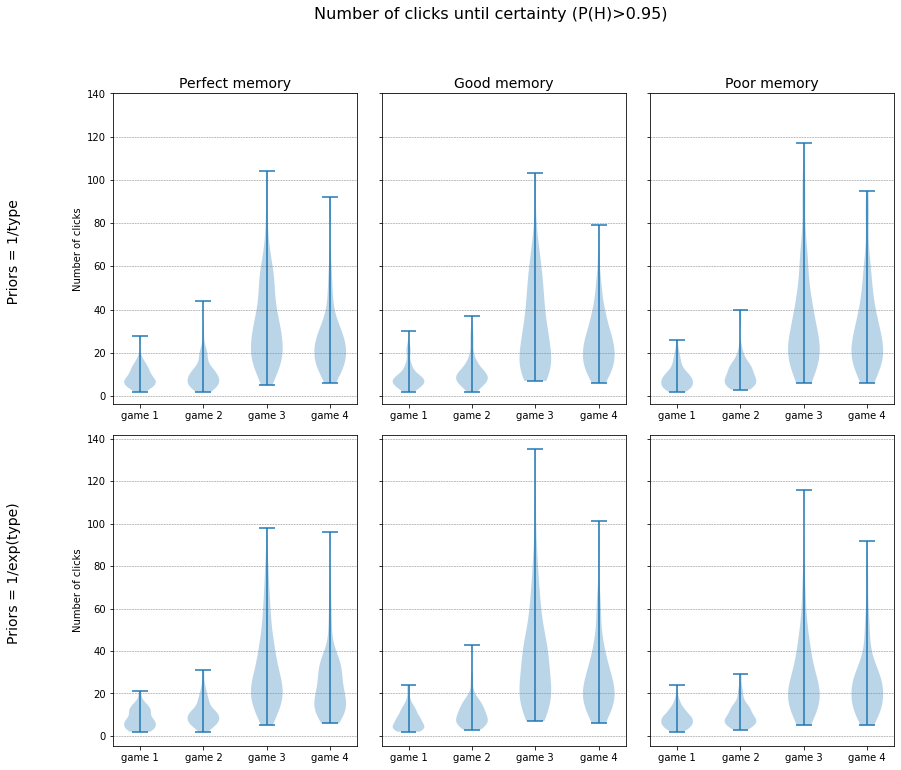

In [131]:
#3x3 plots of all types 
memory_types = [perfect_memory, good_memory, poor_memory]
initialization_types = [initialize_by_type, initialize_exp_by_type]

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(14, 12))
gs = fig.add_gridspec(2, 3, hspace=0.1, wspace=0.1)
(ax1, ax2, ax3), (ax4, ax5, ax6) = gs.subplots(sharey='row')

keys = list(itertools.product(memory_types, initialization_types))
#print(keys)

#memory type 1 (perfect), initialization type 1 (by type)
comb1_data = combination_results[keys[0]]
comb1_data_processed = [comb1_data[game1_score], comb1_data[game2_score], comb1_data[game3_score], comb1_data[game4_score]]
ax1.violinplot(comb1_data_processed)

#memory type 1 (perfect), initialization type 2 (by exp(type))
comb2_data = combination_results[keys[1]]
comb2_data_processed = [comb2_data[game1_score], comb2_data[game2_score], comb2_data[game3_score], comb2_data[game4_score]]
ax4.violinplot(comb2_data_processed)

#memory type 2 (good), initialization type 1 (by type)
comb3_data = combination_results[keys[2]]
comb3_data_processed = [comb3_data[game1_score], comb3_data[game2_score], comb3_data[game3_score], comb3_data[game4_score]]
ax2.violinplot(comb3_data_processed)

#memory type 2 (good), initialization type 2 (by exp(type))
comb4_data = combination_results[keys[3]]
comb4_data_processed = [comb4_data[game1_score], comb4_data[game2_score], comb4_data[game3_score], comb4_data[game4_score]]
ax5.violinplot(comb4_data_processed)

#memory type 3 (poor), initialization type 1 (by type)
comb5_data = combination_results[keys[4]]
comb5_data_processed = [comb5_data[game1_score], comb5_data[game2_score], comb5_data[game3_score], comb5_data[game4_score]]
ax3.violinplot(comb5_data_processed)

#memory type 3 (poor), initialization type 2 (by exp(type))
comb6_data = combination_results[keys[5]]
comb6_data_processed = [comb6_data[game1_score], comb6_data[game2_score], comb6_data[game3_score], comb6_data[game4_score]]
ax6.violinplot(comb6_data_processed)

plt.setp((ax1,ax2,ax3,ax4,ax5,ax6), xticks=[1, 2, 3, 4], xticklabels=['game 1', 'game 2', 'game 3', 'game 4'])
plt.setp((ax1,ax2,ax3,ax4, ax5, ax6), yticks=[0, 20, 40, 60, 80, 100, 120, 140])
plt.setp((ax1,ax4), ylabel="Number of clicks")

ax1.yaxis.grid(color='gray', linestyle='dashed', linewidth=.5)
ax2.yaxis.grid(color='gray', linestyle='dashed', linewidth=.5)
ax3.yaxis.grid(color='gray', linestyle='dashed', linewidth=.5)
ax4.yaxis.grid(color='gray', linestyle='dashed', linewidth=.5)
ax5.yaxis.grid(color='gray', linestyle='dashed', linewidth=.5)
ax6.yaxis.grid(color='gray', linestyle='dashed', linewidth=.5)

ax1.set_title("Perfect memory", fontsize=14)
ax2.set_title("Good memory", fontsize=14)
ax3.set_title("Poor memory", fontsize=14)

fig.supylabel('Priors = 1/exp(type)                                            Priors = 1/type', fontsize=14)
fig.suptitle('Number of clicks until certainty (P(H)>0.95)', fontsize=16);

#### Notes on graphs
It seems as though the output data can vary a fair amount between each set generated, and the different conditions don't have a huge effect. 

Initializing the hypotheses as $1/e^{(\text{type})}$ seems to often decrease the number of clicks as opposed to $1/(\text{type})$, although not always. The differences between perfect, good, and poor memory don't seem to have a consistent effect on the number of clicks until certainty. This could be because testing a hypothesis of low probability could still result in fairly informative observations. Additionally, introducing noise could introduce somem elements of luck where the true hypothesis is randomly weighted very highly, or incorrect hypotheses are set to zero.  

#### Incorporating size principle

Something else we can explore is using the size principle, which gives guidance on not how to initialize hypotheses but how to update hypotheses. Updating hypotheses based on the size prinicple sets the likelihood of observation $x$ as $p(x|h) = \frac{1}{|h|}$, where $|h|$ represents the size of the hypothesis (number of objects in the set $h$). This describes using strong sampling instead of the weak sampling approach we are currently using. 

For each of our hypotheses we can construct the set of all observations that would result in +1 point. For example, for the hypothesis was +1 for red with either a red or black background, then $h$ represents the set of all observations (all combinations of blocks of length 3) with a black or white background. Or if the hypothesis is +1 for clicking blue in black background or +1 for clicking green in white background, then $h$ would be the set of all observations that end witha blue block clicked in a black background or a green block clicked in white background. Finally, for a hypothesis of +1 for clicking red then green then blue, the hypothesis space would be the observation of clicking red then green then blue in all possible combinations of background types for the three hypotheses. These sets could be calculated for each hypothesis a priori. 

However, in strong sampling, it is assumed that the data are intentionally generated as positive examples of a concept, while weak sampling does not make that assumption. Only updating the hypothesis priors when we view a positive example does not seem indicative of what is happening, given people seem to be learning throughout exploring. We could look into using a mixture of the two, for example using methods such as https://onlinelibrary.wiley.com/doi/full/10.1111/j.1551-6709.2011.01212.x

<!---For every observation, every hypothesis is supported by either the outcome 0 or +1.--->